In [1]:
"""
Validation of open-gira power outage model
This notebook compares modelled and observed customer disconnected estimates
Observed data are collated media and goverment reports (CSV files in validation/)
Modelled data are exposure_by_country.nc for the whole IBTrACS storm set
"""

'\nValidation of open-gira power outage model\nThis notebook compares modelled and observed customer disconnected estimates\nObserved data are collated media and goverment reports (CSV files in validation/)\nModelled data are exposure_by_country.nc for the whole IBTrACS storm set\n'

In [14]:
import os
from glob import glob

import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# model outputs
root_path = "/home/fred/projects/open_gira/open-gira/"
tracks_path = os.path.join(root_path, "results/input/IBTrACS/processed/v4.geoparquet")
targets_path = os.path.join(root_path, "results/power/targets_with_iso_a3.geoparquet")
exposure_path = os.path.join(root_path, "results/power/by_storm_set/IBTrACS/exposure_by_country.nc")

# validation data
# https://www.un.org/development/desa/pd/data/household-size-and-composition
household_path = os.path.join(root_path, "undesa_pd_2022_hh-size-composition.xlsx")
# https://gist.githubusercontent.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv
iso_codes = os.path.join(root_path, "iso_codes.csv")
# see source column
outage_paths = glob(os.path.join(root_path, "validation/*.csv"))

In [5]:
# read iso numeric to alpha table
rename_dict = {
    "Country": "name",
    "Alpha-2 code": "iso_a2",
    "Alpha-3 code": "iso_a3",
    "Numeric code": "iso_num"
}
iso = pd.read_csv(iso_codes, usecols=rename_dict.keys())
iso = iso.rename(columns=rename_dict)
# strip out quotes
for c in iso.columns:
    iso[c] = iso[c].str.replace('"', "").str.strip()
iso.iso_num = iso.iso_num.astype(int)

In [6]:
# read household size data
rename_dict = {
    "ISO Code": "iso_num",
    "Reference date (dd/mm/yyyy)": "ref_date",
    "Average household size (number of members)": "mean_household_pop"
}
hh = pd.read_excel(household_path, sheet_name="HH size and composition 2022", header=4, usecols=rename_dict.keys())
hh = hh.rename(columns=rename_dict)
hh.ref_date = pd.to_datetime(hh.ref_date, dayfirst=True)
# any non-numeric value -> NaN (some '..' placeholders in excel data)
hh["mean_household_pop"] = pd.to_numeric(hh["mean_household_pop"], errors="coerce")

# discard all but most recent entry for each territory
hh = hh.sort_values(["ref_date"], ascending=False).drop_duplicates("iso_num", keep="first")

# merge in iso alpha ids (will permit join with outage data)
hh = hh.merge(iso, how="left", on="iso_num")

In [7]:
# now compare population_affected with the exposure_by_country.nc data
ds = xr.open_dataset(exposure_path).rename({"country": "country_iso_a3"})

by_threshold = {}
for threshold in ds.threshold.values:

    # storm loop
    by_storm = {os.path.basename(p).split(".")[0]: pd.read_csv(p) for p in sorted(outage_paths)}
    for event_id, obs in by_storm.items():
            
        obs = obs.rename(columns={"country_iso_a3": "iso_a3"}).merge(hh, how="left", on="iso_a3")

        for i in range(len(obs)):
            # gap-fill the population_affected numbers where we have customers_affected only
            if pd.isna(obs.loc[i, "population_affected"]):
                by_storm[event_id].loc[i, "population_affected"] = \
                    obs.loc[i, "customers_affected"] * obs.loc[i, "mean_household_pop"]

        # take the largest estimate for each country (we assume reports underestimate outages)
        by_storm[event_id] = by_storm[event_id].groupby("country_iso_a3").max()
        by_storm[event_id] = by_storm[event_id][["population_affected"]]
        by_storm[event_id] = by_storm[event_id].rename(columns={"population_affected": "observed"})

        try:
            # select model data for given storm and threshold
            mod = ds.customers_affected.sel(dict(event_id=event_id, threshold=threshold)).to_pandas()
        except KeyError:
            # storm has no modelled results
            continue

        # non-zero modelled customers_affected (really population affected, should change this name!)
        mod = mod[mod > 0]
        mod.name = "modelled"
        by_storm[event_id] = by_storm[event_id].join(mod)
        by_storm[event_id]["error"] = \
            by_storm[event_id].modelled - by_storm[event_id].observed
        by_storm[event_id]["ratio"] = \
            by_storm[event_id].modelled / by_storm[event_id].observed
        by_storm[event_id]["error_norm"] = \
            by_storm[event_id].error / by_storm[event_id].observed

    concat = pd.concat(by_storm)
    concat.index.names = ["event_id", "country_iso_a3"]
    by_threshold[threshold] = concat

In [8]:
# example validation table
by_threshold[27.5]

,,observed,modelled,error,ratio,error_norm
event_id,country_iso_a3,,,,,
2005236N23285,USA,6723000.00,1.673828e+07,1.001528e+07,2.489703,1.489703
2005261N21290,USA,3735000.00,1.063844e+07,6.903441e+06,2.848311,1.848311
2005289N18282,USA,8715000.00,8.219136e+06,-4.958640e+05,0.943102,-0.056898
2008238N13293,USA,2739000.00,1.118749e+07,8.448495e+06,4.084518,3.084518
2008245N17323,USA,9711000.00,1.505843e+07,5.347429e+06,1.550657,0.550657
2011028S13180,AUS,433500.00,5.391484e+05,1.056484e+05,1.243710,0.243710
2011233N15301,USA,16658100.00,2.451955e+07,7.861452e+06,1.471930,0.471930
2012296N14283,USA,21193014.99,5.356912e+07,3.237610e+07,2.527678,1.527678
2013018S14138,AUS,721650.00,NaN,NaN,NaN,NaN


In [9]:
def categorical_cmap(cmap_name: str, categories: list) -> dict[str: tuple[float]]:
    scalar_mappable = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(0, 1), cmap_name)
    return {code: scalar_mappable.to_rgba(i / len(categories)) for i, code in enumerate(categories)}

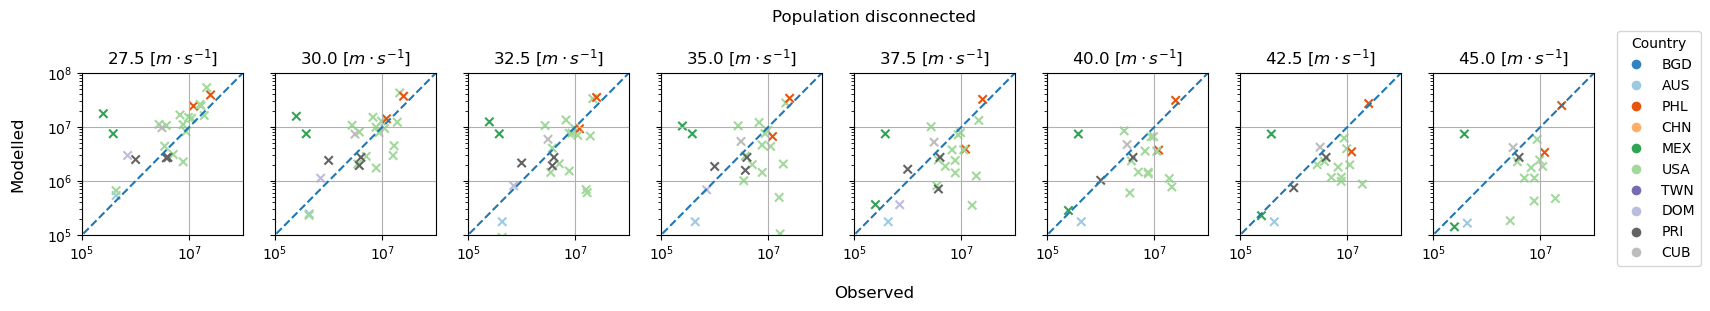

In [10]:
# scatter plot modelled vs. observed by threshold

# make a country colormap
# collect all country codes
iso_codes = set(by_threshold[min(ds.threshold.values)].index.get_level_values("country_iso_a3").values)
# generate RGBA values for each code
cmap = categorical_cmap("tab20c", iso_codes)

n = len(by_threshold.keys())
f, axes = plt.subplots(ncols=n, figsize=(18,3), sharey=True)
for threshold, ax in zip(by_threshold.keys(), axes):
    data = by_threshold[threshold]
    
    # build a list of RGBA values the same length as the data
    colours = [cmap[value] for value in data.index.get_level_values("country_iso_a3").values]

    ax.scatter(data.observed, data.modelled, marker="x", c=colours)
    x = np.linspace(0, 10 * max(data.observed), 100)
    ax.plot(x, x, ls="--")
    ax.grid()
    ax.set_title(f"{threshold} $[m \cdot s^{{-1}}]$")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1E5, 1E8)
    ax.set_ylim(1E5, 1E8)
    
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in cmap.items() if isinstance(k, str)]
ax.legend(title='Country', handles=handles, bbox_to_anchor=(1.1, 1.3))
    
f.supxlabel("Observed")
f.supylabel("Modelled")
f.suptitle("Population disconnected")

plt.subplots_adjust(bottom=0.23, top=0.77, left=0.06, right=0.9)

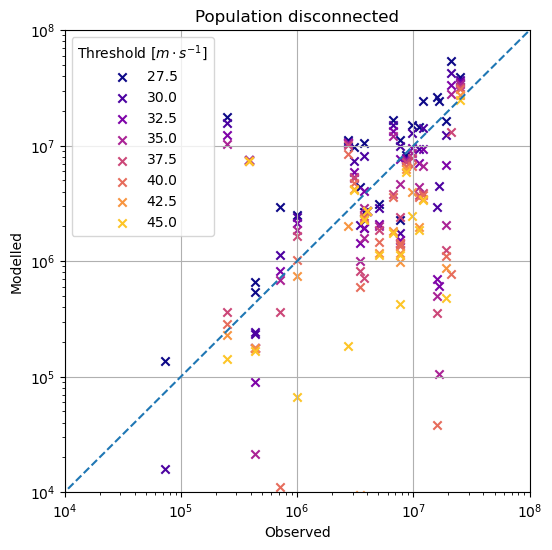

In [11]:
# scatter plot modelled vs. observed by threshold (same plot)

f, ax = plt.subplots(figsize=(6, 6))

cmap = categorical_cmap("plasma", by_threshold.keys())
    
for threshold in by_threshold.keys():
    data = by_threshold[threshold]
    ax.scatter(data.observed, data.modelled, marker="x", label=threshold, color=cmap[threshold])
    
x = np.linspace(0, 10 * max(data.observed), 100)
ax.plot(x, x, ls="--")
ax.grid()
ax.set_title("Population disconnected")
ax.set_xlabel("Observed")
ax.set_ylabel("Modelled")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1E4, 1E8)
ax.set_ylim(1E4, 1E8)
ax.legend(title="Threshold $[m \cdot s^{{-1}}]$")

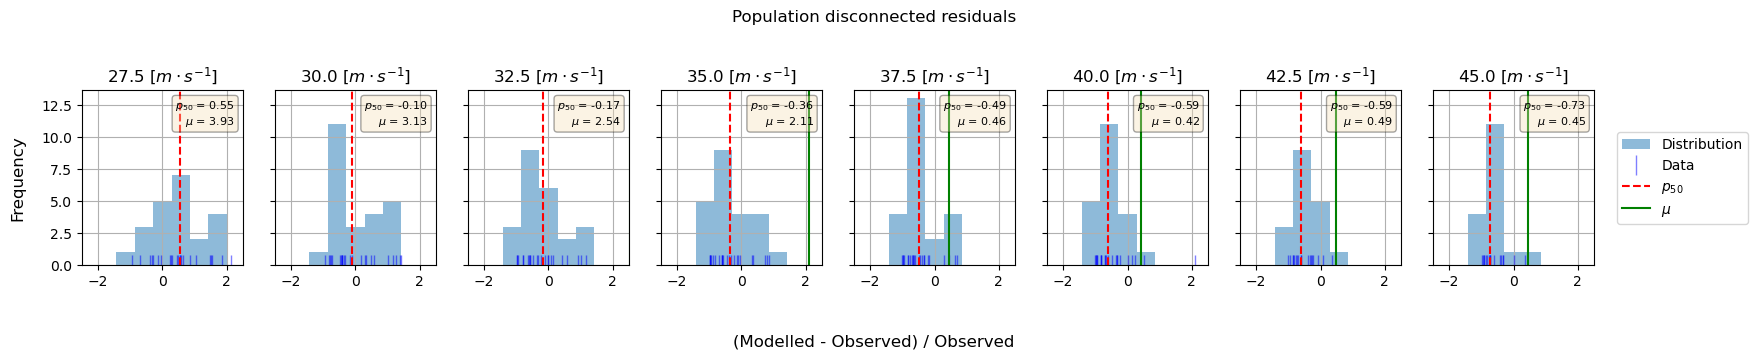

In [12]:
# plot residual distributions by threshold
n = len(by_threshold.keys())
f, axes = plt.subplots(ncols=n, figsize=(18,3.5), sharey=True)
for threshold, ax in zip(by_threshold.keys(), axes):
    e = by_threshold[threshold].error_norm
    
    ax.grid()
    
    # distribution
    ax.hist(
        e,
        bins=np.linspace(-2, 2, 8),
        alpha=0.5,
        label="Distribution"
    )
    
    # rug plot
    ax.plot(e, np.zeros(len(e)), 'b|', ms=15, alpha=0.5, label="Data")
    
    # average measures
    mean = np.nanmean(e)
    median = np.nanmedian(e)
    ax.axvline(median, ls="--", c="red", label=r"$p_{50}$")
    ax.axvline(mean, ls="-", c="green", label=r"$\mu$")


    x_half_width = 2.5
    ax.set_xlim(-x_half_width, x_half_width)
    ax.set_title(f"{threshold} $[m \cdot s^{{-1}}]$")

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.35)
    ax.text(
        0.95,
        0.95,
        "\n".join([f"$p_{{50}}$ = {median:.2f}", f"$\mu$ = {mean:.2f}"]),
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=props
    )
    
ax.legend(bbox_to_anchor=(2, 0.8))

f.supxlabel("(Modelled - Observed) / Observed")
f.supylabel("Frequency")
f.suptitle("Population disconnected residuals")

plt.subplots_adjust(bottom=0.25, top=0.75, left=0.06, right=0.9)

# note that the means are terribly skewed courtesy of a few outliers
# the modelled values for the two Mexican storms especially are significant overestimates   

Text(0, 0.5, 'Frequency')

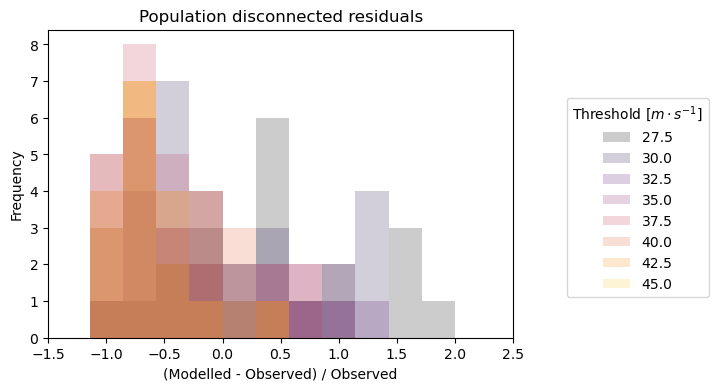

In [13]:
# over plot residual distributions by threshold
f, ax = plt.subplots(figsize=(6, 4))

scalar_mappable = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(0, 1), "inferno")
cmap = {code: scalar_mappable.to_rgba(i / len(by_threshold.keys())) for i, code in enumerate(by_threshold.keys())}

for threshold in by_threshold.keys():
    
    e = by_threshold[threshold].error_norm
    ax.hist(
        e,
        bins=np.linspace(-2, 2, 15),
        alpha=0.2,
        label=threshold,
        color=cmap[threshold]
    )
    
ax.set_xlim(-1.5, 2.5)
ax.legend(title="Threshold $[m \cdot s^{-1}]$", bbox_to_anchor=(1.1, 0.8))
ax.set_title("Population disconnected residuals")
ax.set_xlabel("(Modelled - Observed) / Observed")
ax.set_ylabel("Frequency")